# Logistic Regression

## Binary Classification

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [15]:
breast_cancer_data = load_breast_cancer()
X = breast_cancer_data.data
y = breast_cancer_data.target #labels (0: malignant, 1:begin)
print (breast_cancer_data.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


#### Processing Data and Split them in two Test and Train:

In [16]:
#standardizing the features:
scaler = StandardScaler()
X = scaler.fit_transform(X) #[Appendix 1]

# add bias (x_0 = 1) term to X
X_bias = np.hstack((X, np.ones((X.shape[0], 1))))

X_train, X_val, y_train, y_val = train_test_split(
    X_bias, y, test_size=0.2, random_state=42, stratify=y
)

#### Visualizing Breast Cancer Data

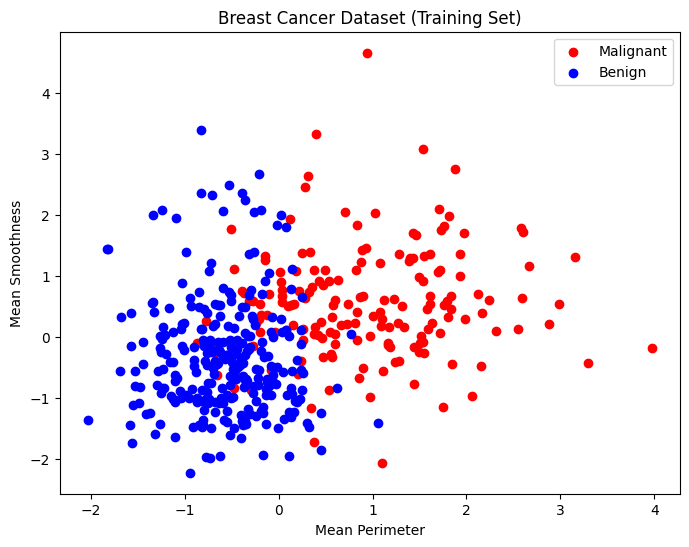

In [17]:
#Visualizing just two features(mean perimeter and mean texture)
X = breast_cancer_data.data[:, [2, 4]]  #selecting third till 5th column



plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', label='Malignant')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Benign')
plt.xlabel('Mean Perimeter')
plt.ylabel('Mean Smoothness')
plt.title('Breast Cancer Dataset (Training Set)')
plt.legend()
plt.show()

#### Defining $\sigma(z) = \frac{1}{1 + e^{-z}}$

In [18]:
def sigma_func(z):
    return 1 / (1 + np.exp(-z))

#### Defining loss function of sigma(Binary Cross-Entropy Loss):
$\text{Loss} = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right)$


In [19]:
def compute_loss(w, X, y):
    z = np.dot(X, w)
    y_predicted = sigma_func(z)
    loss = -np.mean(y * np.log(y_predicted) + (1-y) * np.log(1-y_predicted) )
    return loss

#### Calculate Gradient:


##### Mrhematic Background:

$$\text{Loss} = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right)$$
$$\frac{\partial \text{Loss}}{\partial \beta_j} = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right) x_{ij}$$
$$\text{Error} = y_i - \hat{y}_i$$
$$\textbf{Gradient Calculation:}  \text{gradient} = -\frac{1}{n} X^T (y - \hat{y})$$



In [20]:
def compute_gradient(w, X, y):
    n = X.shape[0]
    z = np.dot(X, w)
    y_predicted = sigma_func(z)
    errors = y - y_predicted
    #the np.dot(X.T, errors) should be averaged over the number of samples to compute 
    #the gradient correctly. Additionally, the np.mean() function should be applied to
    #  the result of the dot product, not directly to the dot product itself. 
    # gradient = -np.mean(np.dot(X.T, errors)) is false
    gradient = - np.dot(X.T, errors) / n
    return gradient

#### Evaluate the performance of a logistic regression model on a validation dataset.

In [21]:
def compute_prediction(w, X_val):
    probabilities = sigma_func(X_val @ w)  # Compute predicted probabilities
    #This line applies a decision rule to classify the predicted probabilities into
    #binary outcomes. If the predicted probability is greater than 0.5, it assigns
    #a label of 1 (positive class); otherwise, it assigns a label of 0 (negative class).
    #The astype(int) method converts the boolean array (True/False) into integers (1/0).
    predictions = (probabilities > 0.5).astype(int)  # Apply decision rule for binary classification
    return predictions

def compute_accuracy(w, X_val, y_val):
    predictions = compute_prediction(w, X_val)
    accuracy = np.mean(predictions == y_val)  # Calculate accuracy
    return accuracy

#### gradient_descent_logistic function:

In [22]:
def gradient_descent_logistic(X_train, y_train,X_val,y_val,
                              learning_rate, steps, tolerance=1e-6 ):
    
    #Q:why using shape[1] and not shape[0]?
    w                    = np.zeros(X_train.shape[1]) # start with all weights equal to 0
    loss_history         = [compute_loss(w, X_train, y_train)]
    val_accuracy_history = [compute_accuracy(w, X_val, y_val)]
    weights_history      = [w.copy()]

    for step in range(1, steps+1):
        grad = compute_gradient(w, X_train, y_train)
        w   -= learning_rate * grad #updating weights
        loss = compute_loss(w, X_train, y_train)
        loss_history.append(loss)

        #Compute Validation Accuracy:
        accuracy = compute_accuracy(w, X_val, y_val)
        val_accuracy_history.append(accuracy)

        # storing weights every 10 steps for plotting
        if step % 10 == 0:
            weights_history.append(w.copy())
        
        # check convergence
        if np.abs(loss_history[-2] - loss_history[-1]) < tolerance:
            print(f'Converged at step {step}')
            break

        if step % 100 == 0:
            print(f'Step {step}: Loss = {loss:.4f}, Validation Accuracy = {accuracy:.4f}')

    return w, loss_history, val_accuracy_history, weights_history


### Training Model:

In [23]:
learning_rate = 0.05
n_steps = 800

w_opt, loss_history, val_accuracy_history, weights_history = gradient_descent_logistic(
    X_train, y_train, X_val, y_val,
    learning_rate, n_steps
)

print(f'Optimized weights: {w_opt}')
print(f'Decision rule: {w_opt[0]} * Mean Perimeter + {w_opt[1]} * Mean Smoothness + {w_opt[2]} > 0 : Benign')
print(f'Decision rule: {w_opt[0]} * Mean Perimeter + {w_opt[1]} * Mean Smoothness + {w_opt[2]} < 0 : Malignant')


Step 100: Loss = 0.1248, Validation Accuracy = 0.9561
Step 200: Loss = 0.0982, Validation Accuracy = 0.9737
Step 300: Loss = 0.0868, Validation Accuracy = 0.9825
Step 400: Loss = 0.0801, Validation Accuracy = 0.9825
Step 500: Loss = 0.0756, Validation Accuracy = 0.9825
Step 600: Loss = 0.0723, Validation Accuracy = 0.9825
Step 700: Loss = 0.0697, Validation Accuracy = 0.9737
Step 800: Loss = 0.0677, Validation Accuracy = 0.9737
Optimized weights: [-0.54873938 -0.6024384  -0.53348615 -0.53622539 -0.25558563 -0.05547351
 -0.38482697 -0.54556916 -0.2003328   0.29696808 -0.57229807  0.01635986
 -0.44282397 -0.48895612 -0.05998582  0.29531212  0.1577224  -0.17562791
  0.17846165  0.34636298 -0.68198711 -0.72408848 -0.63511875 -0.63512197
 -0.50902252 -0.20630864 -0.42891815 -0.64364144 -0.49729861 -0.10967686
  0.3394592 ]
Decision rule: -0.5487393780220486 * Mean Perimeter + -0.60243840047945 * Mean Smoothness + -0.533486154102023 > 0 : Benign
Decision rule: -0.5487393780220486 * Mean Peri

### Ploting

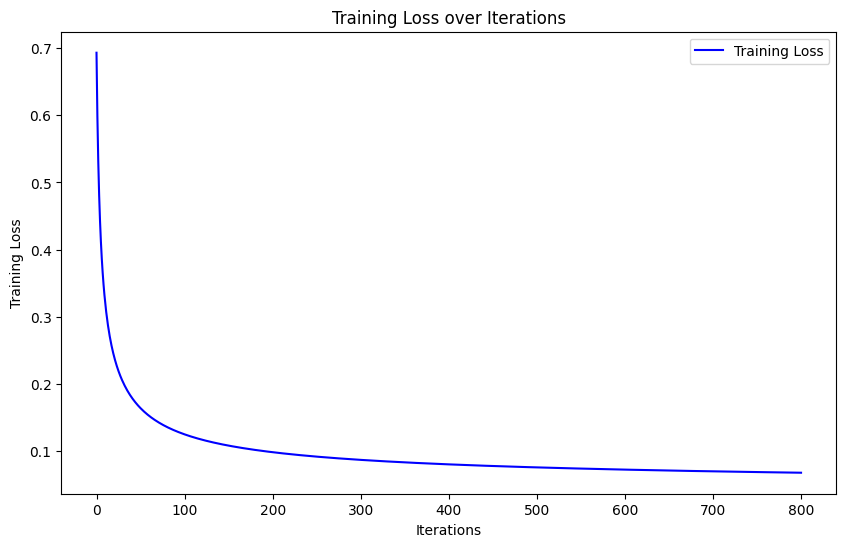

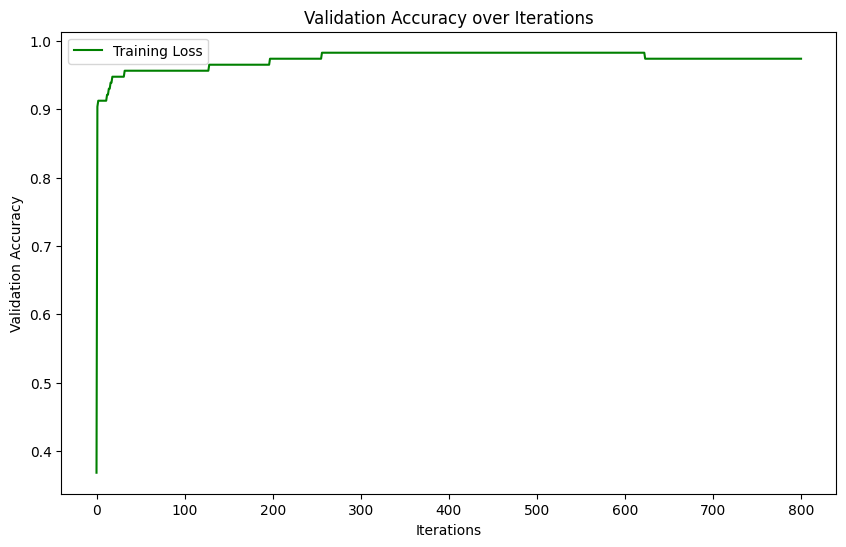

[[41  1]
 [ 2 70]]


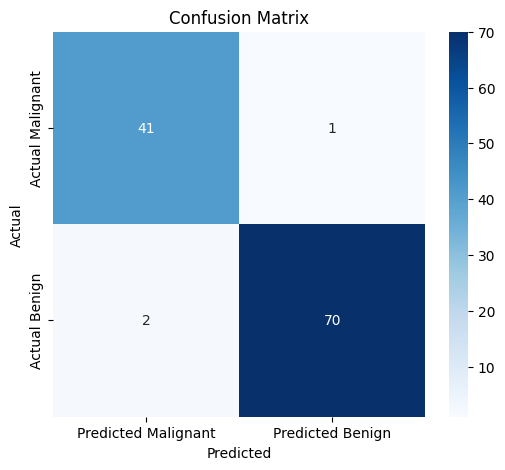

C:\Users\Ramtin\AppData\Local\Temp\ipykernel_2784\1315231653.py:7: RuntimeWarning: invalid value encountered in scalar divide
  plt.axvline(x= -w[2]/w[0], color="green")


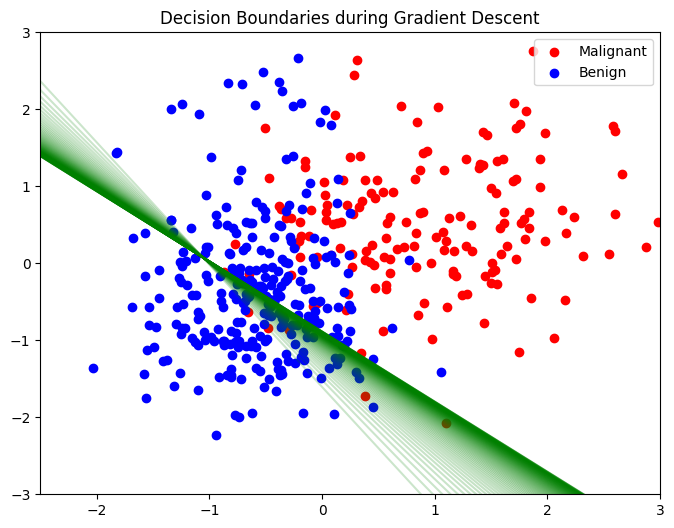

In [45]:
def plot_decision_boundary(w, X, y, step, total_steps):
    x_values = np.array([X[:, 0].min() - 1, X[:, 0].max() + 1])
    if w[1] != 0:
        y_values = -(w[0] * x_values + w[2]) / w[1]
        plt.plot(x_values, y_values, color="green", alpha=(0.20 + (step / total_steps) * 0.20 ) )
    else:
        plt.axvline(x= -w[2]/w[0], color="green")
    plt.legend()

def plot_decision_boundaries(weights_history, X, y, total_steps):
    plt.figure(figsize=(8, 6))
    
    plt.scatter(X[ y == 0, 0 ], X[y == 0, 1], color="red", label="Malignant")
    plt.scatter(X[ y == 1, 0 ], X[y == 1, 1], color='blue', label='Benign')

    plt.xlim(-2.5, 3)
    plt.ylim(-3, 3)
    
    for i, w in enumerate(weights_history):
        step = i * 10
        plot_decision_boundary(w, X, y, step, total_steps)

    plt.title('Decision Boundaries during Gradient Descent')        
    plt.show()


def plot_training_loss(loss_history):
    epochs = range(len(loss_history))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_history, color="blue", label="Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.title("Training Loss over Iterations")
    plt.legend()
    plt.show()

def plot_validation_accuracy(val_accuracy_history):
    epochs = range(len(val_accuracy_history))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_accuracy_history, color="green", label="Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy over Iterations")
    plt.legend()
    plt.show()

def plot_confusion_matrix(w, X_val, y_val):
    predictions  = compute_prediction(w, X_val)
    cm           = confusion_matrix(y_val, predictions)
    print(cm)

    plt.figure(figsize=(6, 5))
    #annot=True : write numbers inside blocks 
    # Use fmt='d' to display confusion matrix values as integers in the heatmap annotations.
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Malignant', 'Predicted Benign'],
                yticklabels=['Actual Malignant', 'Actual Benign'])

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()



plot_training_loss(loss_history)
plot_validation_accuracy(val_accuracy_history)
plot_confusion_matrix(w=w_opt, X_val=X_val, y_val=y_val)
plot_decision_boundaries(weights_history, X_train[:, :2], y_train, n_steps)

## Multi-class classification


## Appendices

### Appendix1

In [46]:
test = [ [10, 20, 30, 40], [10, 20, 30, 40]]
scaler = StandardScaler()
test = scaler.fit_transform(test)

print (test)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]


#### What is `StandardScaler`?

`StandardScaler` is a preprocessing tool provided by the `sklearn.preprocessing` module in the scikit-learn library. It standardizes features by removing the mean and scaling to unit variance. This is particularly important for many machine learning algorithms that are sensitive to the scale of the input data, such as Support Vector Machines (SVM), k-Nearest Neighbors (k-NN), and gradient descent-based algorithms.

#### Why Standardize?

Standardization is important because:
- **Different Scales**: Features in a dataset can have different units and scales (e.g., height in cm and weight in kg). If not standardized, features with larger ranges can dominate the learning process.
- **Improved Convergence**: For algorithms that use gradient descent, standardizing features can lead to faster convergence.
- **Better Performance**: Many machine learning models perform better when the input features are on a similar scale.

#### Code Breakdown

```python
scaler = StandardScaler()
X = scaler.fit_transform(X)
```

1. **Creating an Instance of `StandardScaler`**:
   ```python
   scaler = StandardScaler()
   ```
   - This line creates an instance of the `StandardScaler` class. At this point, the scaler is not yet fitted to any data.

2. **Fitting and Transforming the Data**:
   ```python
   X = scaler.fit_transform(X)
   ```
   - The `fit_transform` method is called on the `scaler` object with the dataset `X` as the input. This method performs two operations:
     - **Fit**: It calculates the mean and standard deviation for each feature in `X`.
     - **Transform**: It standardizes the data using the calculated mean and standard deviation.

#### Example

Let's illustrate this with a simple example.

#### Sample Data

Suppose we have the following dataset with two features:

| Sample | Feature 1 (Height in cm) | Feature 2 (Weight in kg) |
|--------|--------------------------|--------------------------|
| 1      | 150                      | 50                       |
| 2      | 160                      | 60                       |
| 3      | 170                      | 70                       |
| 4      | 180                      | 80                       |
| 5      | 190                      | 90                       |

#### Step 1: Import Libraries and Create Sample Data

```python
import numpy as np
from sklearn.preprocessing import StandardScaler

# Sample data
X = np.array([[150, 50],
              [160, 60],
              [170, 70],
              [180, 80],
              [190, 90]])
```

#### Step 2: Create and Fit the Scaler

```python
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
```

#### Step 3: Understanding the Transformation

- **Calculate Mean and Standard Deviation**:
  - For Feature 1 (Height):
    - Mean = (150 + 160 + 170 + 180 + 190) / 5 = 170
    - Standard Deviation = sqrt(((150-170)² + (160-170)² + (170-170)² + (180-170)² + (190-170)²) / 5) = 14.14 (approximately)
  
  - For Feature 2 (Weight):
    - Mean = (50 + 60 + 70 + 80 + 90) / 5 = 70
    - Standard Deviation = sqrt(((50-70)² + (60-70)² + (70-70)² + (80-70)² + (90-70)²) / 5) = 14.14 (approximately)

- **Standardize Each Feature**:
  - For each sample, apply the standardization formula:
    $
    z = \frac{(x - \text{mean})}{\text{std}}
    $

  - For Sample 1 (Height = 150, Weight = 50):
    - Height: $$ z_1 = \frac{(150 - 170)}{14.14} \approx -1.41 $$
    - Weight: $$ z_2 = \frac{(50 - 70)}{14.14} \approx -1.41 $$

  - Repeat this for all samples.


#### Resulting Standardized Data

After applying the `fit_transform` method, the standardized data `X_standardized` will look like this (values are approximate):

| Sample | Standardized Height | Standardized Weight |
|--------|---------------------|---------------------|
| 1      | -1.41               | -1.41               |
| 2      | -0.71               | -0.71               |
| 3      | 0.00                | 0.00                |
| 4      | 0.71                | 0.71                |
| 5      | 1.41                | 1.41                |

#### Explanation of the Standardized Values

- **Standardized Height**:
  - Sample 1: $$ z = \frac{(150 - 170)}{14.14} \approx -1.41 $$
  - Sample 2: $$ z = \frac{(160 - 170)}{14.14} \approx -0.71 $$
  - Sample 3: $$ z = \frac{(170 - 170)}{14.14} = 0.00 $$
  - Sample 4: $$ z = \frac{(180 - 170)}{14.14} \approx 0.71 $$
  - Sample 5: $$ z = \frac{(190 - 170)}{14.14} \approx 1.41 $$

- **Standardized Weight**:
  - Sample 1: $$ z = \frac{(50 - 70)}{14.14} \approx -1.41 $$
  - Sample 2: $$ z = \frac{(60 - 70)}{14.14} \approx -0.71 $$
  - Sample 3: $$ z = \frac{(70 - 70)}{14.14} = 0.00 $$
  - Sample 4: $$ z = \frac{(80 - 70)}{14.14} \approx 0.71 $$
  - Sample 5: $$ z = \frac{(90 - 70)}{14.14} \approx 1.41 $$

#### Key Points to Remember

1. **Mean of Standardized Features**: After standardization, the mean of each feature will be approximately 0.
2. **Standard Deviation of Standardized Features**: The standard deviation of each feature will be approximately 1.
3. **Interpretation**: The standardized values indicate how many standard deviations a particular value is from the mean. For example, a standardized value of -1.41 means that the original value is 1.41 standard deviations below the mean.

#### Complete Example Code

Here’s the complete code for the example we discussed:

```python
import numpy as np
from sklearn.preprocessing import StandardScaler

# Sample data
X = np.array([[150, 50],
              [160, 60],
              [170, 70],
              [180, 80],
              [190, 90]])

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_standardized = scaler.fit_transform(X)

# Print the standardized data
print("Standardized Data:")
print(X_standardized)

# Print the mean and standard deviation of the standardized data
print("Mean of each feature after standardization:", X_standardized.mean(axis=0))
print("Standard deviation of each feature after standardization:", X_standardized.std(axis=0))
```

#### Output


#### Conclusion

Using `StandardScaler` is a crucial step in preprocessing data for machine learning. It ensures that all features contribute equally to the model's performance by standardizing their scales. This is especially important for algorithms that rely on distance calculations or optimization techniques. By understanding how to use `StandardScaler`, you can effectively prepare your data for various machine learning tasks.